# PI Controller

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

# from IMC tuning
Kc = 4.61730615181
tauI = 0.913444964569
tauD = 0.0


## Define the CSTR model

In [2]:
# define CSTR model
def cstr(x,t,u,Tf,Caf):
    # Inputs (3):
    # Temperature of cooling jacket (K)
    Tc = u
    # Tf = Feed Temperature (K)
    # Caf = Feed Concentration (mol/m^3)

    # States (2):
    # Concentration of A in CSTR (mol/m^3)
    Ca = x[0]
    # Temperature in CSTR (K)
    T = x[1]

    # Parameters:
    # Volumetric Flowrate (m^3/sec)
    q = 100
    # Volume of CSTR (m^3)
    V = 100
    # Density of A-B Mixture (kg/m^3)
    rho = 1000
    # Heat capacity of A-B Mixture (J/kg-K)
    Cp = 0.239
    # Heat of reaction for A->B (J/mol)
    mdelH = 5e4
    # E - Activation energy in the Arrhenius Equation (J/mol)
    # R - Universal Gas Constant = 8.31451 J/mol-K
    EoverR = 8750
    # Pre-exponential factor (1/sec)
    k0 = 7.2e10
    # U - Overall Heat Transfer Coefficient (W/m^2-K)
    # A - Area - this value is specific for the U calculation (m^2)
    UA = 5e4
    # reaction rate
    rA = k0*np.exp(-EoverR/T)*Ca

    # Calculate concentration derivative
    dCadt = q/V*(Caf - Ca) - rA
    # Calculate temperature derivative
    dTdt = q/V*(Tf - T) \
            + mdelH/(rho*Cp)*rA \
            + UA/V/rho/Cp*(Tc-T)
    
    # Return xdot:
    xdot = np.zeros(2)
    xdot[0] = dCadt
    xdot[1] = dTdt
    return xdot

## Define parameters and initial values for the simulation

In [3]:
# Steady State Initial Conditions for the States
Ca_ss = 0.87725294608097
T_ss = 324.475443431599
x0 = np.empty(2)
x0[0] = Ca_ss
x0[1] = T_ss

# Steady State Initial Condition
u_ss = 300.0
# Feed Temperature (K)
Tf = 350
# Feed Concentration (mol/m^3)
Caf = 1

# Time Interval (min)
t = np.linspace(0,25,251)

# Store results for plotting
Ca = np.ones(len(t)) * Ca_ss
T = np.ones(len(t)) * T_ss
u = np.ones(len(t)) * u_ss


# storage for recording values
op = np.zeros(len(t))  # controller output
pv = np.zeros(len(t))  # process variable
e = np.zeros(len(t))   # error
ie = np.zeros(len(t))  # integral of the error
dpv = np.zeros(len(t)) # derivative of the pv
P = np.zeros(len(t))   # proportional
I = np.zeros(len(t))   # integral
D = np.zeros(len(t))   # derivative
sp = np.zeros(len(t))  # set point
sp[0:80] = 300.0
sp[80:150] = 320.0
sp[150:] = 280.0

# Upper and Lower limits on OP
op_hi = 350.0
op_lo = 250.0

## Run the timeloop

In [4]:
pv[0] = T_ss
# loop through time steps    
for i in range(len(t)-1):
    delta_t = t[i+1]-t[i]                       # delta t
    e[i] = sp[i] - pv[i]                        # error
    if i >= 1:                                  # calculate starting on second cycle
        dpv[i] = (pv[i]-pv[i-1])/delta_t        # derivative of the error
        ie[i] = ie[i-1] + e[i] * delta_t        # integral of the error
    P[i] = Kc * e[i]                            # P part of the controller             
    I[i] = Kc/tauI * ie[i]                      # i part of the controller
    D[i] = - Kc * tauD * dpv[i]                 # D part of the controller
    op[i] = op[0] + P[i] + I[i] + D[i]          # combining the contributions to the controller
    if op[i] > op_hi:                           # check upper limit
        op[i] = op_hi
        ie[i] = ie[i] - e[i] * delta_t          # anti-reset windup
    if op[i] < op_lo:                           # check lower limit
        op[i] = op_lo
        ie[i] = ie[i] - e[i] * delta_t          # anti-reset windup
    ts = [t[i],t[i+1]]
    u[i+1] = op[i]                              # Manipulated variable
    y = odeint(cstr,x0,ts,args=(u[i+1],Tf,Caf)) # Solve ODE for the timestep
    Ca[i+1] = y[-1][0]
    T[i+1] = y[-1][1]
    x0[0] = Ca[i+1]
    x0[1] = T[i+1]
    pv[i+1] = T[i+1]
op[len(t)-1] = op[len(t)-2]
ie[len(t)-1] = ie[len(t)-2]
P[len(t)-1] = P[len(t)-2]
I[len(t)-1] = I[len(t)-2]
D[len(t)-1] = D[len(t)-2]

## Post-processing 

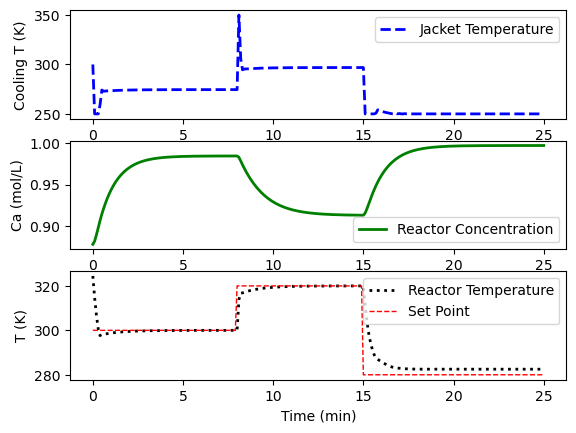

In [6]:
# Construct results and save data file
# Column 1 = time
# Column 2 = cooling temperature
# Column 3 = reactor temperature
data = np.vstack((t,u,T)) # vertical stack
data = data.T             # transpose data
np.savetxt('data_doublet.txt',data,delimiter=',')
    
# Plot the results
plt.figure()
plt.subplot(3,1,1)
plt.plot(t,u,'b--',linewidth=2)
plt.ylabel('Cooling T (K)')
plt.legend(['Jacket Temperature'],loc='best')

plt.subplot(3,1,2)
plt.plot(t,Ca,'g-',linewidth=2)
plt.ylabel('Ca (mol/L)')
plt.legend(['Reactor Concentration'],loc='best')

plt.subplot(3,1,3)
plt.plot(t,T,'k:',linewidth=2,label='Reactor Temperature')
plt.plot(t,sp,'r--',linewidth=1,label='Set Point')
plt.ylabel('T (K)')
plt.xlabel('Time (min)')
plt.legend(loc='best')
